#Data Importing and Preprocessing

## Importing Libraries and Defining General Functions

In [ ]:
pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

import missingno as msno
from datetime import date
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, classification_report, plot_roc_curve
from sklearn.svm import SVC
from lightgbm import LGBMClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV, cross_validate
from sklearn.neighbors import LocalOutlierFactor, KNeighborsClassifier
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, StandardScaler, RobustScaler
from sklearn.ensemble import GradientBoostingClassifier,VotingClassifier, AdaBoostClassifier,RandomForestClassifier
from sklearn.impute import KNNImputer
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
import tensorflow as tf
from datetime import date
from catboost import CatBoostClassifier

In [ ]:
# Pandas Specifications
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.set_option('display.width', 500)

In [ ]:

def outlier_lim(dataframe, col_name, q1=0.01, q3=0.99):
    quartile1 = dataframe[col_name].quantile(q1)
    quartile3 = dataframe[col_name].quantile(q3)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit

def correlation_matrix(df, cols):
    fig = plt.gcf()
    fig.set_size_inches(10, 8)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    fig = sns.heatmap(df[cols].corr(), annot=True, linewidths=0.5, annot_kws={'size': 12}, linecolor='w', cmap='RdBu')
    plt.show(block=True)

def outlier_checker(dataframe, col_name):
    low_limit, up_limit = outlier_lim(dataframe, col_name)
    if dataframe[(dataframe[col_name] > up_limit) | (dataframe[col_name] < low_limit)].any(axis=None):
        return True
    else:
        return False


def col_types(dataframe, cat_th=10, car_th=30):
    """

    Veri setindeki kategorik, numerik ve kategorik fakat kardinal değişkenlerin isimlerini verir.
    Not: Kategorik değişkenlerin içerisine numerik görünümlü kategorik değişkenler de dahildir.

    Parameters
    ------
        dataframe: dataframe
                Dataframe for isnpection
        cat_th: int, optional
                categorical columns that seem like numerical
        car_th: int, optinal
                cardinal columns that seem like categorical

    Returns
    ------
        cat_cols: list
                categorical column names list
        num_cols: list
                numerical column names list
        cat_but_car: list
                cardinal column names list

    Examples
    ------
        import seaborn as sns
        df = sns.load_dataset("iris")
        print(grab_col_names(df))


    Notes
    ------
        cat_cols + num_cols + cat_but_car = toplam değişken sayısı


    """

    # cat_cols, cat_but_car
    cat_cols = [col for col in dataframe.columns if dataframe[col].dtypes == "O"]
    num_but_cat = [col for col in dataframe.columns if dataframe[col].nunique() < cat_th and
                   dataframe[col].dtypes != "O"]
    cat_but_car = [col for col in dataframe.columns if dataframe[col].nunique() > car_th and
                   dataframe[col].dtypes == "O"]
    cat_cols = cat_cols + num_but_cat
    cat_cols = [col for col in cat_cols if col not in cat_but_car]

    # num_cols
    num_cols = [col for col in dataframe.columns if dataframe[col].dtypes != "O"]
    num_cols = [col for col in num_cols if col not in num_but_cat]

    print(f"Observations: {dataframe.shape[0]}")
    print(f"Variables: {dataframe.shape[1]}")
    print(f'cat_cols: {len(cat_cols)}')
    print(f'num_cols: {len(num_cols)}')
    print(f'cat_but_car: {len(cat_but_car)}')
    print(f'num_but_cat: {len(num_but_cat)}')
    return cat_cols, num_cols, cat_but_car


def outlier_rows(dataframe, col_name, index=False, q1=0.01, q2=0.99,prnt=True):
    low, up = outlier_lim(dataframe, col_name, q1, q2)
    if prnt:
        if dataframe[((dataframe[col_name] < low) | (dataframe[col_name] > up))].shape[0] > 10:
            print(dataframe[((dataframe[col_name] < low) | (dataframe[col_name] > up))].head())
        elif dataframe[((dataframe[col_name] < low) | (dataframe[col_name] > up))].shape[0] == 0:
            print("No Outliers\n")
        else:
            print(dataframe[((dataframe[col_name] < low) | (dataframe[col_name] > up))])

    if index:
        outlier_index = dataframe[((dataframe[col_name] < low) | (dataframe[col_name] > up))].index
        return outlier_index


def outlier_remover(dataframe, col_name):
    low_limit, up_limit = outlier_lim(dataframe, col_name)
    df_without_outliers = dataframe[~((dataframe[col_name] < low_limit) | (dataframe[col_name] > up_limit))]
    return df_without_outliers


def outlier_threplacer(dataframe, variable):
    low_limit, up_limit = outlier_lim(dataframe, variable)
    dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit
    dataframe.loc[(dataframe[variable] > up_limit), variable] = up_limit


def missing_col(dataframe, na_name=False):
    na_columns = [col for col in dataframe.columns if dataframe[col].isnull().sum() > 0]

    n_miss = dataframe[na_columns].isnull().sum().sort_values(ascending=False)
    ratio = (dataframe[na_columns].isnull().sum() / dataframe.shape[0] * 100).sort_values(ascending=False)
    missing_df = pd.concat([n_miss, np.round(ratio, 2)], axis=1, keys=['n_miss', 'ratio'])
    print(missing_df, end="\n")

    if na_name:
        return na_columns


def one_hot_encoder(dataframe, categorical_cols, drop_first=True):
    dataframe = pd.get_dummies(dataframe, columns=categorical_cols, drop_first=drop_first)
    return dataframe


def label_encoder(dataframe, binary_col):
    labelencoder = LabelEncoder()
    dataframe[binary_col] = labelencoder.fit_transform(dataframe[binary_col])
    return dataframe


def rare_analyser(dataframe, target, cat_cols):
    for col in cat_cols:
        print(col, ":", len(dataframe[col].value_counts()))
        print(pd.DataFrame({"COUNT": dataframe[col].value_counts(),
                            "RATIO": dataframe[col].value_counts() / len(dataframe),
                            "TARGET_MEAN": dataframe.groupby(col)[target].mean()}), end="\n\n\n")


def rare_encoder(dataframe, rare_perc):
    temp_df = dataframe.copy()

    rare_columns = [col for col in temp_df.columns if temp_df[col].dtypes == 'O'
                    and (temp_df[col].value_counts() / len(temp_df) < rare_perc).any(axis=None)]

    for var in rare_columns:
        tmp = temp_df[var].value_counts() / len(temp_df)
        rare_labels = tmp[tmp < rare_perc].index
        temp_df[var] = np.where(temp_df[var].isin(rare_labels), 'Rare', temp_df[var])

    return temp_df


def importance_plot(model, features, num, save=False):
    feature_imp = pd.DataFrame({'Value': model.feature_importances_, 'Feature': features.columns})
    plt.figure(figsize=(10, 10))
    sns.set(font_scale=1)
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value",
                                                                     ascending=False)[0:num])
    plt.title('Features')
    plt.tight_layout()
    plt.show()
    if save:
        plt.savefig('importances.png')


def cat_prop(dataframe, col_name, plot=False):
    print(pd.DataFrame({col_name: dataframe[col_name].value_counts(),
                        "Ratio": 100 * dataframe[col_name].value_counts() / len(dataframe)}))
    print("##########################################")
    if plot:
        sns.countplot(x=dataframe[col_name], data=dataframe)
        plt.show()

def val_curve_params(model, X, y, param_name, param_range, scoring="roc_auc", cv=10):
    train_score, test_score = validation_curve(
        model, X=X, y=y, param_name=param_name, param_range=param_range, scoring=scoring, cv=cv)

    mean_train_score = np.mean(train_score, axis=1)
    mean_test_score = np.mean(test_score, axis=1)

    plt.plot(param_range, mean_train_score,
             label="Training Score", color='b')

    plt.plot(param_range, mean_test_score,
             label="Validation Score", color='g')

    plt.title(f"Validation Curve for {type(model).__name__}")
    plt.xlabel(f"Number of {param_name}")
    plt.ylabel(f"{scoring}")
    plt.tight_layout()
    plt.legend(loc='best')
    plt.show(block=True)




######Classifier Params



knn_params = {"n_neighbors": range(2, 50, 5)}

cart_params = {'max_depth': range(1, 20),
               "min_samples_split": range(2, 30)}

rf_params = {"max_depth": [8, 15, None],
             "max_features": [5, 7, "auto"],
             "min_samples_split": [15, 20],
             "n_estimators": [200, 300]}

xgboost_params = {"learning_rate": [0.1, 0.01],
                  "max_depth": [5, 8],
                  "n_estimators": [100, 200],
                  "colsample_bytree": [0.5, 1]}

lightgbm_params = {"learning_rate": [0.01, 0.1],
                   "n_estimators": [300, 500],
                   "colsample_bytree": [0.7, 1]}

r_classifiers = [('KNN', KNeighborsClassifier(), knn_params),
               ("CART", DecisionTreeClassifier(), cart_params),
               ("RF", RandomForestClassifier(), rf_params),
               ('XGBoost', XGBClassifier(use_label_encoder=False, eval_metric='logloss'), xgboost_params),
               ('LightGBM', LGBMClassifier(), lightgbm_params)]

classifiers = [('KNN', KNeighborsClassifier(), knn_params),
               ("CART", DecisionTreeClassifier(), cart_params),
               ("RF", RandomForestClassifier(), rf_params),
               ('XGBoost', XGBClassifier(use_label_encoder=False, eval_metric='logloss'), xgboost_params),
               ('LightGBM', LGBMClassifier(), lightgbm_params)]


def base_models(X, y, scoring="roc_auc"):
    print("Base Models....")
    classifiers = [('LR', LogisticRegression()),
                   ('KNN', KNeighborsClassifier()),
                   ("SVC", SVC()),
                   ("CART", DecisionTreeClassifier()),
                   #("RF", RandomForestClassifier()),
                   ('Adaboost', AdaBoostClassifier()),
                   ('GBM', GradientBoostingClassifier()),
                   ('XGBoost', XGBClassifier(use_label_encoder=False, eval_metric='logloss')),
                   ('LightGBM', LGBMClassifier()),
                   # ('CatBoost', CatBoostClassifier(verbose=False))
                   ]

    for name, classifier in classifiers:
        cv_results = cross_validate(classifier, X, y, cv=5, scoring=scoring)
        print(f"{scoring}: {round(cv_results['test_score'].mean(), 4)} ({name}) ")

def random_hyperparameter_optimization(X, y, classifiers_r, cv=5, scoring="roc_auc"):
    print("Hyperparameter Optimization Random Scores....")
    k=0
    for name, classifier, params in classifiers_r:
        print(f"########## {name} ##########")
        cv_results = cross_validate(classifier, X, y, cv=cv, scoring=scoring)
        print(f"{scoring} (Before): {round(cv_results['test_score'].mean(), 4)}")

        gs_best = RandomizedSearchCV(estimator=classifier,
                               param_distributions=params,
                               n_iter=240,  
                               cv=5,
                               verbose=False,
                               n_jobs=-1).fit(X, y)
        final_model = classifier.set_params(**gs_best.best_params_)
        cv_results = cross_validate(final_model, X, y, cv=cv, scoring=scoring)
        print(f"{scoring} (After): {round(cv_results['test_score'].mean(), 4)}")
        print(f"{name} best params: {gs_best.best_params_}", end="\n\n")
        classifiers_r[k,2] = gs_best.best_params_
        k+=1
        print(f"########## RANDOM ##########")
    return classifiers_r

def hyperparameter_optimization(X, y, cv=5, scoring="roc_auc"):
    print("Hyperparameter Optimization....")
    best_models = {}
    for name, classifier, params in classifiers:
        print(f"########## {name} ##########")
        cv_results = cross_validate(classifier, X, y, cv=cv, scoring=scoring)
        print(f"{scoring} (Before): {round(cv_results['test_score'].mean(), 4)}")

        gs_best = GridSearchCV(classifier, params, cv=cv, n_jobs=-1, verbose=False).fit(X, y)
        final_model = classifier.set_params(**gs_best.best_params_)

        cv_results = cross_validate(final_model, X, y, cv=cv, scoring=scoring)
        print(f"{scoring} (After): {round(cv_results['test_score'].mean(), 4)}")
        print(f"{name} best params: {gs_best.best_params_}", end="\n\n")
        best_models[name] = final_model
    return best_models



def voting_classifier(best_models, X, y, m1, m2, m3):
    print("Voting Classifier...")
    voting_clf = VotingClassifier(estimators=[(m1, best_models[m1]), (m2, best_models[m2]),
                                              (m3, best_models[m3])],
                                  voting='soft').fit(X, y)
    cv_results = cross_validate(voting_clf, X, y, cv=5, scoring=["accuracy", "f1", "roc_auc"])
    print(f"Accuracy: {cv_results['test_accuracy'].mean()}")
    print(f"F1Score: {cv_results['test_f1'].mean()}")
    print(f"ROC_AUC: {cv_results['test_roc_auc'].mean()}")
    return voting_clf

def plot_confusion_matrix(y, y_pred):
    acc = round(accuracy_score(y, y_pred), 2)
    cm = confusion_matrix(y, y_pred)
    sns.heatmap(cm, annot=True, fmt=".0f")
    plt.xlabel('y_pred')
    plt.ylabel('y')
    plt.title('Accuracy Score: {0}'.format(acc), size=10)
    plt.show()

##Importing and Understanding the Data

In [ ]:
df_train = pd.read_csv("train.csv")

df_test = pd.read_csv("test.csv")
Y = df_train["failure"]

In [ ]:
df_train.head()

,id,product_code,loading,attribute_0,attribute_1,attribute_2,attribute_3,measurement_0,measurement_1,measurement_2,measurement_3,measurement_4,measurement_5,measurement_6,measurement_7,measurement_8,measurement_9,measurement_10,measurement_11,measurement_12,measurement_13,measurement_14,measurement_15,measurement_16,measurement_17,failure
0,0,A,80.100,material_7,material_8,9,5,7,8,4,18.040,12.518,15.748,19.292,11.739,20.155,10.672,15.859,17.594,15.193,15.029,NaN,13.034,14.684,764.100,0
1,1,A,84.890,material_7,material_8,9,5,14,3,3,18.213,11.540,17.717,17.893,12.748,17.889,12.448,17.947,17.915,11.755,14.732,15.425,14.395,15.631,682.057,0
2,2,A,82.430,material_7,material_8,9,5,12,1,5,18.057,11.652,16.738,18.240,12.718,18.288,12.715,15.607,NaN,13.798,16.711,18.631,14.094,17.946,663.376,0
3,3,A,101.070,material_7,material_8,9,5,13,2,6,17.295,11.188,18.576,18.339,12.583,19.060,12.471,16.346,18.377,10.020,15.250,15.562,16.154,17.172,826.282,0
4,4,A,188.060,material_7,material_8,9,5,9,2,8,19.346,12.950,16.990,15.746,11.306,18.093,10.337,17.082,19.932,12.428,16.182,12.760,13.153,16.412,579.885,0


In [ ]:
df_train.shape

(26570, 26)

In [ ]:
df_test.head()

,id,product_code,loading,attribute_0,attribute_1,attribute_2,attribute_3,measurement_0,measurement_1,measurement_2,measurement_3,measurement_4,measurement_5,measurement_6,measurement_7,measurement_8,measurement_9,measurement_10,measurement_11,measurement_12,measurement_13,measurement_14,measurement_15,measurement_16,measurement_17
0,26570,F,119.570,material_5,material_6,6,4,6,9,6,19.305,10.178,17.534,18.168,11.598,18.654,10.802,15.909,18.070,13.772,13.659,16.825,13.742,17.710,634.612
1,26571,F,113.510,material_5,material_6,6,4,11,8,0,17.883,11.927,17.228,16.033,11.179,19.368,12.032,13.998,NaN,12.473,17.468,16.708,14.776,14.102,537.037
2,26572,F,112.160,material_5,material_6,6,4,8,12,4,18.475,10.481,16.619,18.189,12.126,17.774,11.743,17.046,18.086,10.907,13.363,15.737,17.065,16.021,658.995
3,26573,F,112.720,material_5,material_6,6,4,8,11,10,16.518,10.888,15.293,18.592,11.304,18.948,11.790,18.165,16.163,10.933,15.501,15.667,12.620,16.111,594.301
4,26574,F,208.000,material_5,material_6,6,4,14,16,8,17.808,12.693,17.678,15.814,13.431,19.141,12.370,14.578,17.849,11.941,16.070,16.183,13.324,17.150,801.044


In [ ]:
df_test.shape

(20775, 25)

In [ ]:
df_train["failure"].value_counts()

0    20921
1     5649
Name: failure, dtype: int64

Train dataset is unbalanced

##Checking For Outliers and wrong data inputs

In [ ]:
cat_cols, num_cols, car_cols = col_types(df_train)

Observations: 26570
Variables: 26
cat_cols: 6
num_cols: 20
cat_but_car: 0
num_but_cat: 3


outlier_rows is a local function that shows outliers according to interquartile range

In [ ]:
for col in num_cols:
    outlier_r = outlier_rows(df_train,col,index=True,q1 = 0.05, q2 = 0.95,prnt=False)
    print("Outlier Rows For Column {}".format(col))
    print(df_train.iloc[outlier_r].sort_values(by=col,ascending=False).head())
    print("-------------------------------------------------------------------------\n")

Outlier Rows For Column id
Empty DataFrame
Columns: [id, product_code, loading, attribute_0, attribute_1, attribute_2, attribute_3, measurement_0, measurement_1, measurement_2, measurement_3, measurement_4, measurement_5, measurement_6, measurement_7, measurement_8, measurement_9, measurement_10, measurement_11, measurement_12, measurement_13, measurement_14, measurement_15, measurement_16, measurement_17, failure]
Index: []
-------------------------------------------------------------------------

Outlier Rows For Column loading
Empty DataFrame
Columns: [id, product_code, loading, attribute_0, attribute_1, attribute_2, attribute_3, measurement_0, measurement_1, measurement_2, measurement_3, measurement_4, measurement_5, measurement_6, measurement_7, measurement_8, measurement_9, measurement_10, measurement_11, measurement_12, measurement_13, measurement_14, measurement_15, measurement_16, measurement_17, failure]
Index: []
--------------------------------------------------------------

missing_col is local function that show missing row numbers in columns

In [ ]:
missing_col(df_train)

                n_miss  ratio
measurement_17    2284  8.600
measurement_16    2110  7.940
measurement_15    2009  7.560
measurement_14    1874  7.050
measurement_13    1774  6.680
measurement_12    1601  6.030
measurement_11    1468  5.530
measurement_10    1300  4.890
measurement_9     1227  4.620
measurement_8     1048  3.940
measurement_7      937  3.530
measurement_6      796  3.000
measurement_5      676  2.540
measurement_4      538  2.020
measurement_3      381  1.430
loading            250  0.940


In [ ]:
missing_col(df_test)

                n_miss  ratio
measurement_17    1740  8.380
measurement_16    1678  8.080
measurement_15    1542  7.420
measurement_14    1440  6.930
measurement_13    1303  6.270
measurement_12    1240  5.970
measurement_11    1136  5.470
measurement_10    1067  5.140
measurement_9      904  4.350
measurement_8      846  4.070
measurement_7      720  3.470
measurement_6      624  3.000
measurement_5      508  2.450
measurement_4      409  1.970
measurement_3      329  1.580
loading            223  1.070


There is no outlier but missing data is quite large and we cannot remove them because there will be enormous data loss

##Correlations and distrubutions

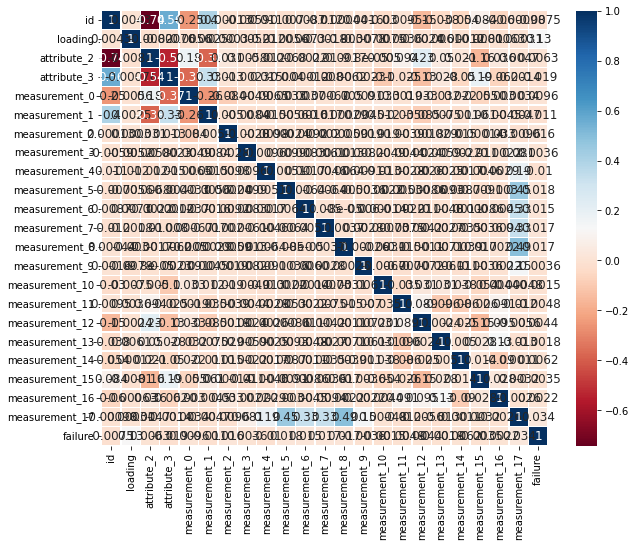

In [ ]:
correlation_matrix(df_train,df_train.columns)

There is a negative correlation between attribute_2 and id but because we do not know the definitions of the features we cannot remove any column

## Encoding and handling the missing data

Drop the target, id and product code columns

In [ ]:
df_train = df_train.drop(["failure"],axis=1)
df_train = df_train.drop(["product_code"],axis=1)
df_train = df_train.drop(["id"],axis=1)
test_id = df_test["id"]
df_test = df_test.drop(["id"],axis=1)
df_test = df_test.drop(["product_code"],axis=1)

Product_code column dropped because it gives no information about test data codes for test data and train data is different and this column may cause overfitting

In [ ]:
cat_cols, num_cols, car_cols = col_types(df_train)

Observations: 26570
Variables: 23
cat_cols: 4
num_cols: 19
cat_but_car: 0
num_but_cat: 2


Merge train and test dataset 

In [ ]:
df_len = len(df_train)

In [ ]:
df_train = pd.concat([df_train, df_test],ignore_index=True)

Convert categorical columns into numerical features

In [ ]:
tmpAry_0 = []
tmpAry_1 = []
for rows in range(len(df_train)):
    tmp_0 = int(df_train['attribute_0'][rows].split('_')[1])
    tmpAry_0.append(tmp_0)
    tmp_1 = int(df_train['attribute_1'][rows].split('_')[1])
    tmpAry_1.append(tmp_1)
df_train['attribute_0'] = tmpAry_0
df_train['attribute_1'] = tmpAry_1


In [ ]:
df_train.head()

,loading,attribute_0,attribute_1,attribute_2,attribute_3,measurement_0,measurement_1,measurement_2,measurement_3,measurement_4,measurement_5,measurement_6,measurement_7,measurement_8,measurement_9,measurement_10,measurement_11,measurement_12,measurement_13,measurement_14,measurement_15,measurement_16,measurement_17
0,80.100,7,8,9,5,7,8,4,18.040,12.518,15.748,19.292,11.739,20.155,10.672,15.859,17.594,15.193,15.029,NaN,13.034,14.684,764.100
1,84.890,7,8,9,5,14,3,3,18.213,11.540,17.717,17.893,12.748,17.889,12.448,17.947,17.915,11.755,14.732,15.425,14.395,15.631,682.057
2,82.430,7,8,9,5,12,1,5,18.057,11.652,16.738,18.240,12.718,18.288,12.715,15.607,NaN,13.798,16.711,18.631,14.094,17.946,663.376
3,101.070,7,8,9,5,13,2,6,17.295,11.188,18.576,18.339,12.583,19.060,12.471,16.346,18.377,10.020,15.250,15.562,16.154,17.172,826.282
4,188.060,7,8,9,5,9,2,8,19.346,12.950,16.990,15.746,11.306,18.093,10.337,17.082,19.932,12.428,16.182,12.760,13.153,16.412,579.885


Standartize the columns and fill the na columns with KNNImputer

In [ ]:
cat_cols, num_cols, car_cols = col_types(df_train)
scaler_tr = StandardScaler()
df_train[num_cols+cat_cols] = pd.DataFrame(scaler_tr.fit_transform(df_train[num_cols+cat_cols]), columns=num_cols+cat_cols)


imputer_tr = KNNImputer(n_neighbors=5)
df_train[num_cols] = pd.DataFrame(imputer_tr.fit_transform(df_train[num_cols]), columns=num_cols)



Observations: 47345
Variables: 23
cat_cols: 4
num_cols: 19
cat_but_car: 0
num_but_cat: 4


In [ ]:
df_train.head()

,loading,attribute_0,attribute_1,attribute_2,attribute_3,measurement_0,measurement_1,measurement_2,measurement_3,measurement_4,measurement_5,measurement_6,measurement_7,measurement_8,measurement_9,measurement_10,measurement_11,measurement_12,measurement_13,measurement_14,measurement_15,measurement_16,measurement_17
0,-1.219,0.707,1.549,1.223,-1.017,-0.103,-0.129,-0.620,0.247,0.787,-1.382,1.783,0.025,1.120,-0.753,-0.177,-0.920,2.361,-0.529,0.906,-1.301,-1.102,0.497
1,-1.096,0.707,1.549,1.223,-1.017,1.569,-1.299,-0.901,0.420,-0.190,0.584,0.381,1.033,-1.130,1.023,1.236,-0.715,-0.028,-0.767,-0.451,-0.422,-0.539,-0.152
2,-1.159,0.707,1.549,1.223,-1.017,1.091,-1.767,-0.338,0.264,-0.078,-0.394,0.729,1.003,-0.734,1.291,-0.347,-0.056,1.392,0.818,1.750,-0.616,0.837,-0.300
3,-0.682,0.707,1.549,1.223,-1.017,1.330,-1.533,-0.056,-0.497,-0.542,1.441,0.828,0.868,0.032,1.046,0.153,-0.418,-1.234,-0.352,-0.357,0.714,0.377,0.989
4,1.543,0.707,1.549,1.223,-1.017,0.374,-1.533,0.507,1.551,1.219,-0.142,-1.771,-0.408,-0.928,-1.089,0.651,0.579,0.440,0.394,-2.279,-1.224,-0.075,-0.961


Split two sets 

In [ ]:
df_test = df_train.iloc[df_len:]

In [ ]:
df_test.shape

(20775, 23)

In [ ]:
df_train = df_train.iloc[:df_len]

In [ ]:
df_train.shape

(26570, 23)

## Model Building Automated Hyperparameter Optimization

In [ ]:
base_models(df_train, Y)

Base Models....
roc_auc: 0.5921 (LR) 
roc_auc: 0.5116 (KNN) 
roc_auc: 0.51 (SVC) 
roc_auc: 0.51 (CART) 
roc_auc: 0.5767 (Adaboost) 
roc_auc: 0.5583 (GBM) 
roc_auc: 0.5624 (XGBoost) 
roc_auc: 0.537 (LightGBM) 


Best models for dataset is  DecisionTreeClassifier and
LGBMClassifier

Cross validate results for base LGBM Classifier Example Model to inspect confusion matrix

In [ ]:
lgbm_model = LGBMClassifier()
lgbm_model.get_params()
cv_results = cross_validate(lgbm_model, df_train, Y, cv=5, scoring=["accuracy", "f1", "roc_auc"])
print(cv_results['test_accuracy'].mean())
print(cv_results['test_roc_auc'].mean())
print(cv_results['test_f1'].mean())

0.5853970643582989
0.5369653686161959
0.14545088048764057


Confusion matrix is an important indicator because dataset is unbalanced and model's f1 score is extremely low

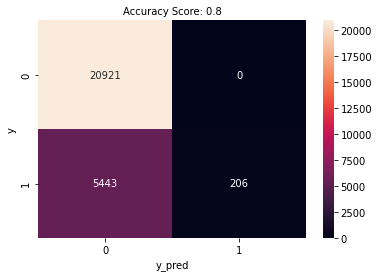

In [ ]:
lgbm_model = LGBMClassifier().fit(df_train,Y)
y_pred = lgbm_model.predict(df_train)
plot_confusion_matrix(Y,y_pred)

We can see that the Type II error percentage is the fundamental problem

###Hyperparameter optimization of all models

Decrease the class weight of 0 because of Type II error 


In [ ]:
weights = np.linspace(0.1,0.21,3)

In [ ]:
dict_w = [{0:x, 1:1.0-x} for x in weights]

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df_train, Y, test_size=0.2)

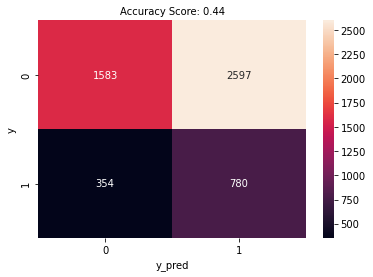

In [ ]:
lgbm_model = LGBMClassifier(class_weight=[{0:x, 1:1.0-x} for x in weights][1]).fit(X_train,y_train)
y_pred = lgbm_model.predict(X_test)
plot_confusion_matrix(y_test,y_pred)

Type II problem can be solved with appropriate class_weight parameter

In [ ]:

cart_params = {'max_depth': range(1, 12),
               "min_samples_split": range(2, 20),
               "class_weight":dict_w}

rf_params = {"max_depth": [8, 15, None],
             "max_features": [5, 7, "auto"],
             "min_samples_split": [15, 20],
             "n_estimators": [200, 300],
             "class_weight":dict_w}



lightgbm_params = {"learning_rate": [0.01, 0.1],
                   "n_estimators": [300, 500],
                   "colsample_bytree": [0.7, 1],
                   "class_weight":dict_w}

catBoost_params = {"iterations": [200, 500],
                   "learning_rate": [0.01, 0.1],
                   "depth": [3, 6],
                   "class_weights":dict_w}

classifiers = [("CART", DecisionTreeClassifier(), cart_params),
               ("RF", RandomForestClassifier(), rf_params),
               ('LightGBM', LGBMClassifier(), lightgbm_params)  ,       
               ('CatBoost', CatBoostClassifier(verbose=False), catBoost_params)]

In [ ]:
best_models = hyperparameter_optimization(df_train, Y)

Hyperparameter Optimization....
########## CART ##########
roc_auc (Before): 0.5087
roc_auc (After): 0.5655
CART best params: {'class_weight': {0: 0.21, 1: 0.79}, 'max_depth': 2, 'min_samples_split': 2}

########## RF ##########
roc_auc (Before): 0.532
roc_auc (After): 0.5253
RF best params: {'class_weight': {0: 0.21, 1: 0.79}, 'max_depth': None, 'max_features': 7, 'min_samples_split': 15, 'n_estimators': 300}

########## LightGBM ##########
roc_auc (Before): 0.537
roc_auc (After): 0.5373
LightGBM best params: {'class_weight': {0: 0.21, 1: 0.79}, 'colsample_bytree': 1, 'learning_rate': 0.1, 'n_estimators': 500}

########## CatBoost ##########
roc_auc (Before): 0.5463
roc_auc (After): 0.5379
CatBoost best params: {'class_weights': {0: 0.21, 1: 0.79}, 'depth': 6, 'iterations': 500, 'learning_rate': 0.1}



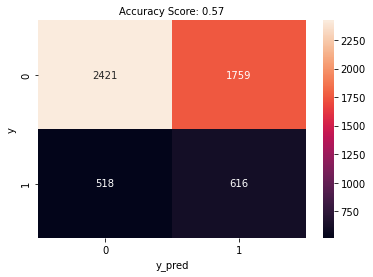

In [ ]:
CART = best_models["CART"].fit(X_train,y_train)
y_pred = CART.predict(X_test)
plot_confusion_matrix(y_test,y_pred)

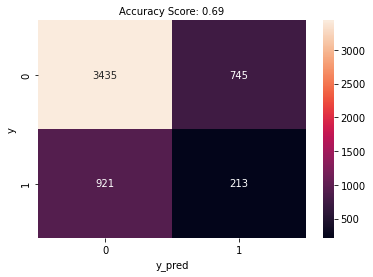

In [ ]:
lgbm_model = best_models["LightGBM"].fit(X_train,y_train)
y_pred = lgbm_model.predict(X_test)
plot_confusion_matrix(y_test,y_pred)

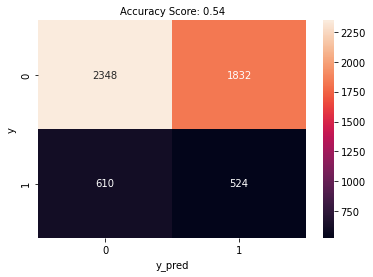

In [ ]:
lgbp = {'class_weight': {0: 0.11, 1: 1-0.11}, 'colsample_bytree': 1, 'learning_rate': 0.1, 'n_estimators': 500}
lgbm_model = LGBMClassifier(**lgbp).fit(X_train,y_train)
y_pred = lgbm_model.predict(X_test)
plot_confusion_matrix(y_test,y_pred)

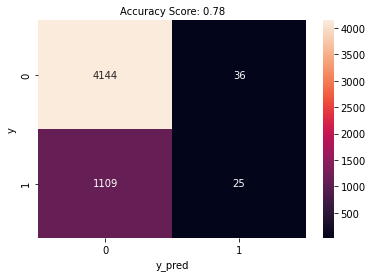

In [ ]:
rf_mod = best_models["RF"].fit(X_train,y_train)
y_pred = rf_mod.predict(X_test)
plot_confusion_matrix(y_test,y_pred)

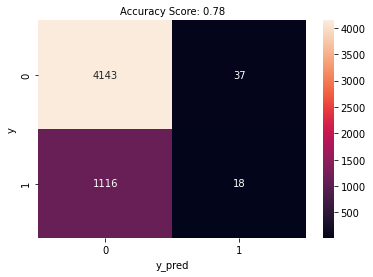

In [ ]:
rf_p = {'class_weight': {0: 0.21, 1: 0.79}, 'max_depth': None, 'max_features': 7, 'min_samples_split': 15, 'n_estimators': 300}
rf_mod = RandomForestClassifier(**rf_p).fit(X_train,y_train)
y_pred = rf_mod.predict(X_test)
plot_confusion_matrix(y_test,y_pred)

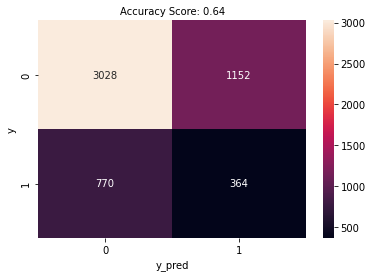

In [ ]:
catb = best_models["CatBoost"].fit(X_train,y_train)
y_pred = catb.predict(X_test)
plot_confusion_matrix(y_test,y_pred)

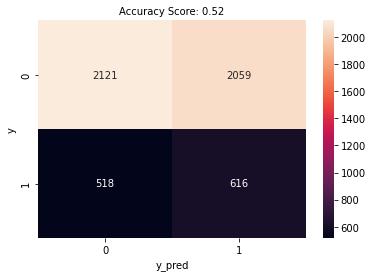

In [ ]:
catb_p = {'class_weights': {0: 0.15, 1: 1-0.15}, 'depth': 6, 'iterations': 500, 'learning_rate': 0.1}
catb = CatBoostClassifier(verbose=False,**catb_p).fit(X_train,y_train)
y_pred = catb.predict(X_test)
plot_confusion_matrix(y_test,y_pred)

Stacking and Ensemble Learning

In [ ]:
voting_clf = VotingClassifier(estimators=[ ("LightGBM", lgbm_model),
                                            ("CAT", catb),
                                            ("CART", CART)],
                                voting='soft').fit(df_train, Y)
cv_results = cross_validate(voting_clf, df_train, Y, cv=5, scoring=["accuracy", "f1", "roc_auc"])
print(f"Accuracy: {cv_results['test_accuracy'].mean()}")
print(f"F1Score: {cv_results['test_f1'].mean()}")
print(f"ROC_AUC: {cv_results['test_roc_auc'].mean()}")

Accuracy: 0.5388407978923598
F1Score: 0.21648602395163657
ROC_AUC: 0.5617250863040886


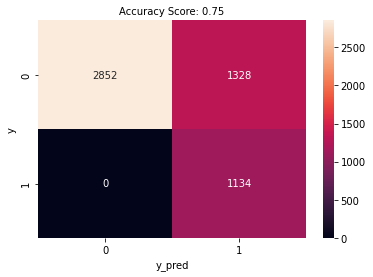

In [ ]:
y_pred = voting_clf.predict(X_test)
plot_confusion_matrix(y_test,y_pred)

Voting Classifier for better result

In [ ]:
y_pred = voting_clf.predict(df_test)
target = pd.read_csv("test.csv")
csvd = pd.DataFrame(target["id"])
csvd["failure"] = y_pred

compression_opts = dict(method='zip',
                        archive_name='vc.csv')
csvd.to_csv('vc.zip', index=False,
          compression=compression_opts)

## Deep Learning

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df_train, Y, test_size=0.2)
Y = pd.DataFrame(Y)

Hyperparameter optimization

In [51]:
best_acc = 0
params = [8,128]
layer = [64,32,16,8]
batchsize = [64,128,512,256]

for k in range(4):
  for j in range(4):
      input_size = len(X_train.columns)
      output_size = len(Y.columns)
      hidden_layer_size = layer[k]
          

      ann_model = tf.keras.models.Sequential([
          tf.keras.layers.Dense(hidden_layer_size, activation='relu'),
          tf.keras.layers.Dense(hidden_layer_size, activation='relu'), # 1st hidden layer
          tf.keras.layers.Dense(hidden_layer_size, activation='relu'),


# 2nd hidden layer
          tf.keras.layers.Dense(output_size, activation='sigmoid') # output layer
      ])



      ann_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

      batch_size = batchsize[j]

      max_epochs = 100



      

      ann_model.fit(X_train, 
                y_train,
                batch_size=batch_size, 
                epochs=max_epochs,  
                validation_data=(X_test, y_test),
                verbose = 0,
                class_weight={0: 0.11, 1: 1-0.11}
                ) 
      test_loss, test_accuracy = ann_model.evaluate(X_test, y_test)

      if best_acc < test_accuracy:
        best_acc =  test_accuracy
        params[0] = layer[k]
        params[1] = batchsize[j]
      tf.keras.backend.clear_session()

167/167 [==============================] - 0s 2ms/step - loss: 0.9666 - accuracy: 0.2422


Founded best parameters for model

In [52]:
best_acc

0.5993601679801941

In [57]:
params

[64, 64]

In [54]:
tf.keras.backend.clear_session()

Build the model with best parameters

In [55]:
input_size = len(X_train.columns)
output_size = len(Y.columns)
hidden_layer_size = params[0]
    

ann_modelnew = tf.keras.models.Sequential([

    tf.keras.layers.Dense(hidden_layer_size, activation='relu'),
    tf.keras.layers.Dense(hidden_layer_size, activation='relu'), # 1st hidden layer
    tf.keras.layers.Dense(hidden_layer_size, activation='relu'), # 2nd hidden layer
    tf.keras.layers.Dense(output_size, activation='sigmoid') # output layer
])



ann_modelnew.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

batch_size = params[1]

max_epochs = 100




ann_modelnew.fit(X_train, 
          y_train,
          batch_size=batch_size, 
          epochs=max_epochs, 
          validation_data=(X_test, y_test), 
          verbose = 0,
          class_weight={0: 0.11, 1: 1-0.11}
          ) 
test_loss, test_accuracy = ann_modelnew.evaluate(X_test, y_test)

167/167 [==============================] - 0s 2ms/step - loss: 1.9619 - accuracy: 0.6137


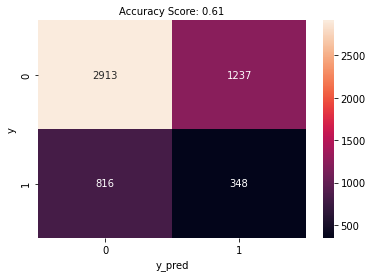

In [56]:
y_pred = ann_modelnew.predict(X_test)
y_pred = (y_pred > 0.5).astype(int)
plot_confusion_matrix(y_test,y_pred)

Predict the test data targets

In [58]:
y_pred = ann_modelnew.predict(df_test)
y_pred = (y_pred > 0.5).astype(int)

In [59]:
target = pd.read_csv("test.csv")
csvd = pd.DataFrame(target["id"])
csvd["failure"] = y_pred

compression_opts = dict(method='zip',
                        archive_name='deep.csv')
csvd.to_csv('deep.zip', index=False,
          compression=compression_opts)

#Voting Classifier has the best results according to f1 score and confusion matrix 